In [1]:
# Libraries
import torch
from torch import nn, einsum
import torch.nn.functional as f
import cv2
import numpy as np
import matplotlib.pyplot as plt
import einops
from einops import rearrange

In [2]:
# Custom Libraries 
from backbone import Backbone
from neck_bak import swin_t_neck
from neck import Neck
from head import Head
from model import Model

In [3]:
# Creating the model
backbone = Backbone(hid_dim=96, layers=[2, 2, 2, 2], heads=[3, 6, 12, 24])
neck = swin_t_neck(hid_dim=96, layers=[2,2,2,2], heads=[24, 12, 6, 3], channels=768)
neck_t = Neck(hid_dim=96, layers=[2,2,2,2], heads=[24, 12, 6, 3], channels=768)
head = Head(in_channels=96, num_classes=1)
# model = Model(backbone, neck, head)

/home/schecter/miniconda3/envs/pikachu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mod = Model(backbone, neck_t, head)

torch.Size([1, 3, 896, 1600])


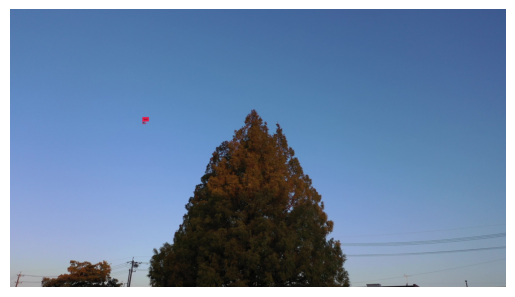

In [5]:
# Loading image
img = cv2.cvtColor(cv2.imread("../assets/annotated_image.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1600, 896))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
print(data.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

# This is Nishant_Trial

torch.Size([1, 3, 896, 1600])


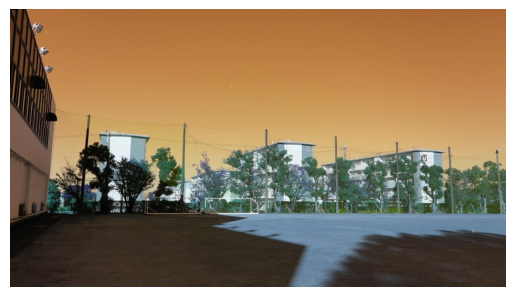

In [6]:
img = cv2.cvtColor(cv2.imread("../assets/sample_run.jpeg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1600, 896))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
print(data.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

#These are the bounding box of all the small objects.
bbox_values = torch.tensor([[2035,1003,9,17], [795,1169,9,17], [2715,1524,9,17], [263,209,9,17], [931,844,9,17], [1621,1398,9,17]]).float()
#Other bbox values are [795,1169,9,17], [2715,1524,9,17], [263,209,9,17], [931,844,9,17], [1621,1398,9,17]


In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# data = data.to(device)

In [8]:
P_heatmap, P_width, P_height, P_offset  = mod(data)

Input shape: torch.Size([1, 50, 28, 768]), Feature map shape: torch.Size([1, 50, 28, 768])
features:  torch.Size([1, 224, 400, 96])
torch.Size([1, 96, 224, 400])
1


In [9]:
P_heatmap = einops.rearrange(P_heatmap, 'b c h w -> h (w c b)')
P_width = einops.rearrange(P_width, 'b c h w -> h (w c b)')
P_height = einops.rearrange(P_height, 'b c h w -> h (w c b)')
P_offset = einops.rearrange(P_offset, 'b c h w -> (c b) h w')

In [27]:
# Generating ground truth

def calculate_offset(image_size, bbox):
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    offset_x = x_center / image_size[1]
    offset_y = y_center / image_size[0]
    return offset_x, offset_y

def calculate_width_height(bbox):
    width = bbox[2]
    height = bbox[3]
    return width, height

def generate_ground_truth(image_size, bboxs):
    heatmap = np.zeros(image_size)
    widthmap = np.zeros(image_size)
    heightmap = np.zeros(image_size)
    offsetmap = np.zeros((2,image_size[0], image_size[1]))
    for bbox in bboxs:
        x_center = int((bbox[0] + bbox[2]) / 2)
        y_center = int((bbox[1] + bbox[3]) / 2)
        heatmap[x_center, y_center] = 1 
        width, height = calculate_width_height(bbox) # Set the center of the bounding box to 1
        widthmap[x_center, y_center] = width
        heightmap[x_center, y_center] =  height
        offset = calculate_offset(image_size, bbox)
        offsetmap[0,x_center, y_center] = offset[0]
        offsetmap[1,x_center, y_center] = offset[1]
        
        print(f"X_center: {x_center}, Y_center: {y_center}, Width: {width}, Height: {height}, Offset: {offset}")
    return heatmap, widthmap, heightmap, offsetmap

In [34]:
# G_heatmap, G_width, G_height, G_offset = generate_ground_truth((2160, 3840), bbox_values)
G_heatmap, G_width, G_height, G_offset = generate_ground_truth((2160, 3840), bbox_values)

X_center: 1022, Y_center: 510, Width: -2026.0, Height: -986.0, Offset: (tensor(0.2661), tensor(0.2361))
X_center: 402, Y_center: 593, Width: -786.0, Height: -1152.0, Offset: (tensor(0.1047), tensor(0.2745))
X_center: 1362, Y_center: 770, Width: -2706.0, Height: -1507.0, Offset: (tensor(0.3547), tensor(0.3567))
X_center: 136, Y_center: 113, Width: -254.0, Height: -192.0, Offset: (tensor(0.0354), tensor(0.0523))
X_center: 470, Y_center: 430, Width: -922.0, Height: -827.0, Offset: (tensor(0.1224), tensor(0.1993))
X_center: 815, Y_center: 707, Width: -1612.0, Height: -1381.0, Offset: (tensor(0.2122), tensor(0.3275))


In [29]:
# G_heatmap = torch.tensor(G_heatmap).float()
# G_width = torch.tensor(G_width).float()
# G_height = torch.tensor(G_height).float()
# G_offset = torch.tensor(G_offset).float()

In [12]:
P_heatmap = f.interpolate(P_heatmap.unsqueeze(0).unsqueeze(0).float(), size=(G_heatmap.shape[0], G_heatmap.shape[1]), mode='bilinear', align_corners=False)
P_heatmap = einops.rearrange(P_heatmap, 'b c h w -> h (w c b)')

In [14]:
loss = f.binary_cross_entropy_with_logits(P_heatmap, G_heatmap)

TypeError: 'int' object is not callable

In [ ]:
loss

tensor(1.0592, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
import numpy as np
# Assuming the array is named "arr"
threshold = 0.7
filtered_arr = np.where(F_heatmap.detach().numpy() > threshold, F_heatmap.detach().numpy(), 0)


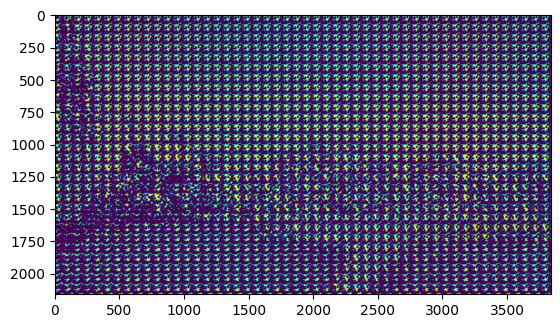

In [ ]:
plt.imshow(filtered_arr)

In [ ]:
print(filtered_arr[filtered_arr > 0.7].shape)

(1936491,)


In [ ]:
filtered_arr = np.where(G_heatmap.detach().numpy() > threshold, G_heatmap.detach().numpy(), 0)

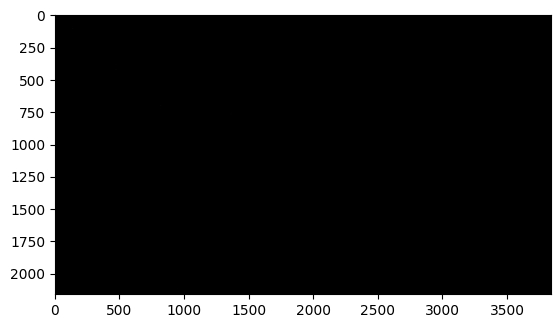

In [ ]:
plt.imshow(filtered_arr, cmap='gray')


In [ ]:
print(filtered_arr[filtered_arr > 0.7].shape)


(6,)


In [ ]:
loss = f.binary_cross_entropy_with_logits(f.sigmoid(F_heatmap), f.sigmoid(G_heatmap))

In [ ]:
loss

tensor(0.7455, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
loss = f.binary_cross_entropy_with_logits(f.sigmoid(torch.tensor(filtered_arr)), f.sigmoid(G_heatmap))


In [ ]:
loss

tensor(0.7298, dtype=torch.float64)

In [ ]:
P_heatmap.shape

torch.Size([224, 400])

In [ ]:
P_width.shape

torch.Size([224, 400])